# Preparation

In [1]:
import iminuit
%load_ext line_profiler
import matplotlib.pyplot as plt
%matplotlib inline
import numba
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
from scipy import optimize
import seaborn as sns
from theano.compile.ops import as_op
import theano.tensor as tt

sns.set_style('darkgrid')
sns.set_context('notebook')

In [2]:
results = pd.DataFrame()

# Load C14 models

In [3]:
import c14_models

# Read patient data

In [4]:
c14_patient_data = pd.read_excel('data/C14data_liver_samples.xlsx')[['sort', 'Code', 'DOB', 'DOA', u'Δ 14C']]
c14_patient_data.columns = ['type', 'pub_id', 'Dbirth', 'Dcoll', 'd14C']
c14_patient_data['mass'] = 1.0
c14_patient_data['d14C'] /= 1000.0

In [5]:
exp_data = c14_patient_data.query('type == "hepatocyte"')
exp_data.describe()

,Dbirth,Dcoll,d14C,mass
count,19.000000,19.000000,19.000000,19.0
mean,1964.021930,2015.605263,0.043114,1.0
std,20.059938,3.810909,0.021048,0.0
min,1932.583333,2004.833333,0.017700,1.0
25%,1946.166667,2016.458333,0.027331,1.0
50%,1964.000000,2016.750000,0.039600,1.0
75%,1981.250000,2017.125000,0.051000,1.0
max,1995.333333,2017.416667,0.090351,1.0


# SSE & log-likelihood

In [6]:
def SSE(p, model, data):
    model_data = model(data['Dbirth'].values, 
                    data['Dcoll'].values, 
                    *p)
    sse = np.sum((model_data - data['d14C'].values)**2)
    return sse    

In [7]:
def Sigma(p, model, data):
    sse = SSE(p, model, data)
    n = len(data)
    sigma = np.sqrt(sse/n)
    return sigma

In [8]:
def Nloglike(p, model, data):
    try:
        sse = SSE(p, model, data)
    except:
        sse = SSE([p], model, data)
    n = len(data)
    sig = np.sqrt(sse/n)
    loglike = -n/2 * np.log(2*np.pi) - n/2 * np.log(sig**2) - 1 / (2*sig**2) * sse
    return -loglike

# Scenario I1

In [9]:
@np.vectorize
def I1(Dbirth, Dcoll, loglam):
    lam = np.exp(loglam)
    return c14_models.I1(Dbirth, Dcoll, lam, t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

## Fit

In [10]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(np.log(0.01), np.log(10.0))],
                  args = (I1, exp_data),
                  Ns = 50,
                  full_output = True,
                  finish=None)

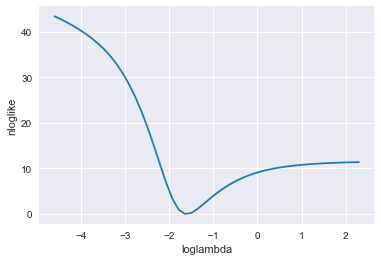

In [11]:
plt.plot(res[-2], res[-1]-res[1])

plt.xlabel('loglambda')
plt.ylabel('nloglike')

plt.show()

## Result

In [12]:
lam = sp.exp(res[0])
print('lamda', lam)

sig = Sigma([np.log(lam)], I1, exp_data)
print('sigma', sig)

results.loc['I1', 'loglike'] = -res[1]
results.loc['I1', 'k'] = 2
results.loc['I1', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

lamda 0.193069772888
sigma 0.0168354005996


,loglike,k,n,cAIC
I1,50.641325,2.0,19.0,-96.53265


# IK

In [13]:
@np.vectorize
def IK(Dbirth, Dcoll, loglam, f):
    lam = np.exp(loglam)
    return c14_models.IK(Dbirth, Dcoll, lam, f, t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

## Fit

In [14]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(-1.5, 1), (0.2, 0.95)],
                  args = (IK, exp_data),
                  Ns = 20,
                  full_output = True,
                  finish=None)

print(res[0])
print(res[1])

[-0.57894737  0.35789474]
-50.6767518261


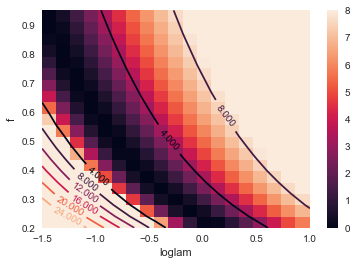

In [15]:
x = res[2][0]
y = res[2][1]
z = res[3]
z -= z.min()

CS = plt.contour(x, y, z)
plt.pcolormesh(x, y, z, vmax=8)

plt.clabel(CS, inline=1, fontsize=10)

plt.xlabel('loglam')
plt.ylabel('f')
plt.colorbar()

plt.show()

## Result

In [16]:
lam = sp.exp(res[0][0])
print('lamda', lam)

f = res[0][1]
print('f', f)

sig = Sigma([np.log(lam), f], IK, exp_data)
print('sigma', sig)

results.loc['IK', 'loglike'] = -res[1]
results.loc['IK', 'k'] = 3
results.loc['IK', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

lamda 0.560488043569
f 0.357894736842
sigma 0.0168040391187


,loglike,k,n,cAIC
I1,50.641325,2.0,19.0,-96.532650
IK,50.676752,3.0,19.0,-93.753504


# IL

In [17]:
@np.vectorize
def IL(Dbirth, Dcoll, loglam, f):
    lam = np.exp(loglam)
    return c14_models.IL(Dbirth, Dcoll, lam, f, t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

## Fit

In [18]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(-2, 2), (0.01, 0.99)],
                  args = (IL, exp_data),
                  Ns = 20,
                  full_output = True,
                  finish=None)

print(res[0])
print(res[1])

[-1.15789474  0.47421053]
-50.7317642285


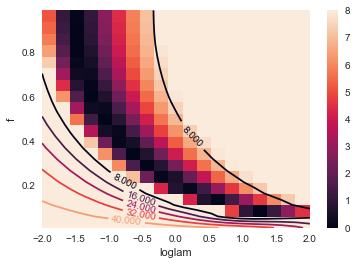

In [19]:
x = res[2][0]
y = res[2][1]
z = res[3]
z -= z.min()

CS = plt.contour(x, y, z)
plt.pcolormesh(x, y, z, vmax=8)

plt.clabel(CS, inline=1, fontsize=10)

plt.xlabel('loglam')
plt.ylabel('f')
plt.colorbar()

plt.show()

## Result

In [20]:
lam = sp.exp(res[0][0])
print('lamda', lam)

f = res[0][1]
print('f', f)

sig = Sigma([np.log(lam), f], IL, exp_data)
print('sigma', sig)

results.loc['IL', 'loglike'] = -res[1]
results.loc['IL', 'k'] = 3
results.loc['IL', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

lamda 0.314146846984
f 0.474210526316
sigma 0.0167554552472


,loglike,k,n,cAIC
I1,50.641325,2.0,19.0,-96.532650
IK,50.676752,3.0,19.0,-93.753504
IL,50.731764,3.0,19.0,-93.863528


# I2

In [21]:
@np.vectorize
def I2(Dbirth, Dcoll, loglam, f):
    lam = np.exp(loglam)
    return c14_models.I2(Dbirth, Dcoll, lam, f, 
                         t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

## Fit

In [22]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(-3, 0.5), (0.85, 1)],
                  args = (I2, exp_data),
                  Ns = 20,
                  full_output = True,
                  finish=None)

print(res[0])
print(res[1])

[-1.52631579  0.99210526]
-50.5808207182


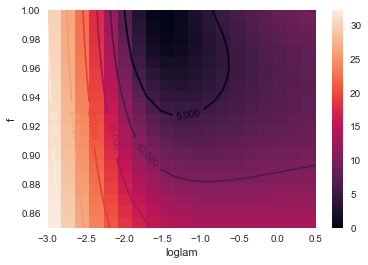

In [23]:
x = res[2][0]
y = res[2][1]
z = res[3]
z -= z.min()

CS = plt.contour(x, y, z)
plt.pcolormesh(x, y, z)

plt.clabel(CS, inline=1, fontsize=10)

plt.xlabel('loglam')
plt.ylabel('f')
plt.colorbar()

plt.show()

In [24]:
lam = sp.exp(res[0][0])
print('lamda', lam)

f = res[0][1]
print('f', f)

sig = Sigma([np.log(lam), f], I2, exp_data)
print('sigma', sig)

results.loc['I2', 'loglike'] = -res[1]
results.loc['I2', 'k'] = 3
results.loc['I2', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

lamda 0.217334901671
f 0.992105263158
sigma 0.0168890973567


,loglike,k,n,cAIC
I1,50.641325,2.0,19.0,-96.532650
IK,50.676752,3.0,19.0,-93.753504
IL,50.731764,3.0,19.0,-93.863528
I2,50.580821,3.0,19.0,-93.561641


# Scenario IX2p

In [25]:
@np.vectorize
def IX2p(Dbirth, Dcoll, dloglam1, dloglam2, f1):
    dlam1 = np.exp(dloglam1)
    dlam2 = np.exp(dloglam2)
    
    f2 = 1-f1
    
    return c14_models.IX(Dbirth, Dcoll, [dlam1, dlam2], [f1, f2],
                        t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

## Fit

In [26]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(np.log(0.01), np.log(2.0)),(np.log(0.01), np.log(2.0)) , (0, 1)],
                  args = (IX2p, exp_data),
                  Ns = 10,
                  full_output = True,
                  finish=None)

print(res[0])
print(res[1])

[-2.8390644  -0.48425668  0.22222222]
-51.5940985725


## Result

In [27]:
results.loc['IX2p', 'loglike'] = -res[1]
results.loc['IX2p', 'k'] = 4
results.loc['IX2p', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

,loglike,k,n,cAIC
I1,50.641325,2.0,19.0,-96.532650
IK,50.676752,3.0,19.0,-93.753504
IL,50.731764,3.0,19.0,-93.863528
I2,50.580821,3.0,19.0,-93.561641
IX2p,51.594099,4.0,19.0,-92.331054


# Results

In [28]:
results.sort_values('cAIC')

,loglike,k,n,cAIC
I1,50.641325,2.0,19.0,-96.532650
IL,50.731764,3.0,19.0,-93.863528
IK,50.676752,3.0,19.0,-93.753504
I2,50.580821,3.0,19.0,-93.561641
IX2p,51.594099,4.0,19.0,-92.331054
